#1 Introduccion

El ejercicio a continuación consiste en trasladar una imagen pasando como parametros las coordenadas X e Y.  
El codigo basicamente consiste en ir trasladando cada unos de los pixeles de la imagen origen a una nueva coordenada en la imagen destino.

#2 Armado del ambiente
Se toma la dirección web de una imagen con acceso público en internet, la cual la deja disponible al contexto de ejecución del cuaderno Colab.

In [ ]:
#@title # 2.1 Parámetros de ejecución
#@markdown ---
#@markdown ### Especifique la URL de la imagen:
url_imagen = "https://as.com/meristation/imagenes/2021/01/20/noticias/1611162270_013847_1611162672_noticia_normal.jpg" #@param {type:"string"}

!wget {url_imagen} -O imagen.jpg

--2021-07-04 02:10:35--  https://as.com/meristation/imagenes/2021/01/20/noticias/1611162270_013847_1611162672_noticia_normal.jpg
Resolving as.com (as.com)... 199.232.198.133, 199.232.194.133
Connecting to as.com (as.com)|199.232.198.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87043 (85K) [image/jpeg]
Saving to: ‘imagen.jpg’

imagen.jpg          100%[===================>]  85.00K  --.-KB/s    in 0.01s   

2021-07-04 02:10:35 (8.72 MB/s) - ‘imagen.jpg’ saved [87043/87043]



##2.2 Instalacion del modulo CUDA de Python

In [ ]:
!pip install pycuda

     |████████████████████████████████| 1.7MB 7.3MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 11.7MB/s 
     |████████████████████████████████| 71kB 9.1MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627583 sha256=e662a1252e7302f371375ac9057d8fe0999e431a3255b8b58407c41322fe9d01
  Stored in directory: /root/.cache/pip/wheels/d5/55/64/fd4dddcc5f1c25eebd90b5291c3769101dc978c70165685512
Successfully built pycuda
  Created wheel for pytools: filename=pytools-2021.2.7-py2.py3-none-any.whl size=60644 sha256=102590d7b6eab35080d14a6c3595b6d8d508d9cad16e2d9b50f2f298174cd8f6
  Stored in directory: /root/.cache/pip/wheels/a0/b5/e5/e65d25997fd77729b9aa214645add18688483e48bbcbab6ffc
Successfully built pytools


#3 Desarrollo
Se solicita primeramente las coordenadas X e Y para realizar la traslacion de la imagen:

Imagen del filtro: imagen.jpg -RGB- [1200, 675]
Thread: [ 16 , 19  ], Bloque : [ 75 , 36 ]
Total de Thread: [ 1200 , 684  ]  =  820800
Tiempo TOTAL:  1045.81 [ms]
Tiempo GPU  :  1.806 [ms]


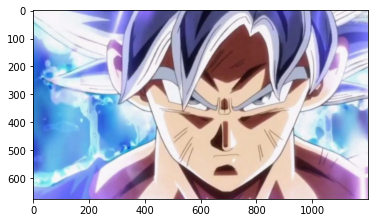

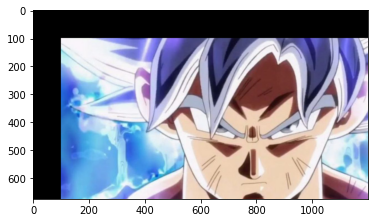

In [ ]:
%matplotlib inline
from datetime import datetime
tiempo_total = datetime.now()

import matplotlib.pyplot as plt
import numpy
from PIL import Image 
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

#---------------------------------
# Se piden los datos de traslacion X e Y:

#@markdown ### Especifique valores de X e Y:
traslacion_x =  100#@param {type:"integer"}
traslacion_y =  100#@param {type:"integer"}
#---------------------------------

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------

img_nombre = 'imagen.jpg'
image = Image.open( img_nombre ) 
  
# summarize some details about the image 
img_ancho, img_alto = image.size 

# Se convierte la imagen comprimida en JPEG/PNG a array
img_O_cpu = numpy.asarray(image)
img_R_cpu = numpy.empty_like( img_O_cpu)

# Se reserva los 2 vectores en GPU(3 pixeles usa RGB * (el tamaño del array))
img_O_gpu = cuda.mem_alloc( img_O_cpu.nbytes )
img_R_gpu = cuda.mem_alloc( img_R_cpu.nbytes )

# GPU - Se copia la memoria al GPU.
cuda.memcpy_htod( img_O_gpu, img_O_cpu )
cuda.memcpy_htod( img_R_gpu, img_R_cpu )

# CPU - Se definen las dos funciónes kernel que se ejecutaran en GPU:
# kernel_img es la que realiza la traslacion
# kernel_img_black pinta la imagen destino de color negro (previo a la traslacion)

module = SourceModule("""
__global__ void kernel_img( int ancho, int alto, char *img_O, char *img_R, int tras_x, int tras_y )
{
  // Calculo las coordenadas del Thread en dos dimensiones.
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  int idy = threadIdx.y + blockIdx.y*blockDim.y;
  
  // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
  if( idx < ancho && idy < alto )
  {
    // Calculo el color gris para el pixel a partir de los componentes.
    /*
     fGris = (float)img_O[(idx+(idy*ancho))*3    ]*0.299;  // Componente Rojo del pixel.
     fGris +=(float)img_O[((idx+(idy*ancho))*3)+1]*0.599;  // Componente Verde del pixel.
     fGris +=(float)img_O[((idx+(idy*ancho))*3)+2]*0.11;   // Componente Azul del pixel.
     
     //Escribo el color del pixel.
     img_R[(idx+(idy*ancho))*3  ] = (char) fGris;
     img_R[(idx+(idy*ancho))*3+1] = (char) fGris;
     img_R[(idx+(idy*ancho))*3+2] = (char) fGris;
    */ 

    // Valores x e y harcodeados  
    //tras_x = 200;
    //tras_y = 500;
    
    int idxx = idx + tras_x;
    int idyy = idy + tras_y;
    
    if(idxx < ancho && idyy < alto){
    img_R[(idxx + (idyy * ancho))*3  ] =  img_O[(idx+(idy*ancho))*3];
    img_R[((idxx + (idyy * ancho))*3)+1] =  img_O[((idx+(idy*ancho))*3)+1];
    img_R[((idxx + (idyy * ancho))*3)+2] =  img_O[((idx+(idy*ancho))*3)+2];
    }
  }
}

__global__ void kernel_img_black( int ancho, int alto, char *img_O, char *img_R )
{
  // Calculo las coordenadas del Thread en dos dimensiones.
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  int idy = threadIdx.y + blockIdx.y*blockDim.y;

  // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
  if( idx < ancho && idy < alto )
  {
    // Pongo el pixel en negro
    img_R[(idx+(idy*ancho))*3  ] = 0;
    img_R[(idx+(idy*ancho))*3+1] = 0;
    img_R[(idx+(idy*ancho))*3+2] = 0;
  }

}

""") 

# Muestro los atributos de la imagen y como se ve antes del seudo filtro.
print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

# CPU - Se generan dos funciónes kernel.
kernel = module.get_function("kernel_img")
kernel_dos = module.get_function("kernel_img_black")

tiempo_img = datetime.now()

dim_hilo_x = 16
dim_bloque_x = numpy.int( (img_ancho+dim_hilo_x-1) / dim_hilo_x )

dim_hilo_y = 19
dim_bloque_y = numpy.int( (img_alto+dim_hilo_y-1) / dim_hilo_y )

print( "Thread: [", dim_hilo_x, ",", dim_hilo_y, " ], Bloque : [", dim_bloque_x, ",", dim_bloque_y, "]" )
print( "Total de Thread: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y )

tiempo_img = datetime.now()

# Se ejecutan las funciones Kernel por separado
kernel_dos( numpy.int32(img_ancho), numpy.int32(img_alto), img_O_gpu, img_R_gpu, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )
kernel( numpy.int32(img_ancho), numpy.int32(img_alto), img_O_gpu, img_R_gpu, numpy.int32(traslacion_x), numpy.int32(traslacion_y), block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )

tiempo_img = datetime.now() - tiempo_img

# GPU - Se copia el resultado desde la memoria GPU.
cuda.memcpy_dtoh( img_R_cpu, img_R_gpu )

# Se muestra la imagen Original
plt.figure()
imgplot=plt.imshow( img_O_cpu )

# Se muestra la imagen luego de realizar la traslacion.
plt.figure()
imgplot=plt.imshow( img_R_cpu )

tiempo_total = datetime.now() - tiempo_total

print("Tiempo TOTAL: ", tiempo_en_ms( tiempo_total ), "[ms]" )
print("Tiempo GPU  : ", tiempo_en_ms( tiempo_img ), "[ms]" )